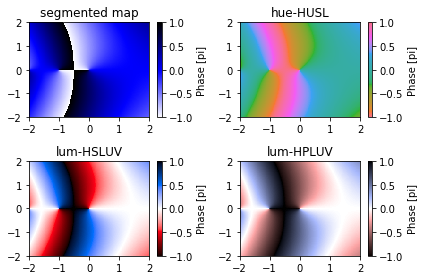

In [5]:
#halfangle is what I use
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as col
import seaborn as sns
import hsluv # pip install hsluv
import scipy.special # just for the example function

##### generate custom colormaps
def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap
def make_segmented_cmap(): 
    white = '#ffffff'
    black = '#000000'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

def make_anglemap( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = 11.6 # red 
    h[N//2:] = 258.6 # blue
    s = 100 # saturation
    l = np.linspace(0, 100, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )

    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s, l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s, l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

N = 256
segmented_cmap = make_segmented_cmap()
flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))
hsluv_anglemap = make_anglemap( use_hpl = False )
hpluv_anglemap = make_anglemap( use_hpl = True )

##### generate data grid
x = np.linspace(-2,2,N)
y = np.linspace(-2,2,N)
z = np.zeros((len(y),len(x))) # make cartesian grid
for ii in range(len(y)): 
    z[ii] = np.arctan2(y[ii],x) # simple angular function
    z[ii] = np.angle(scipy.special.gamma(x+1j*y[ii])) # some complex function

##### plot with different colormaps
fig = plt.figure(1)
fig.clf()
colormapnames = ['segmented map', 'hue-HUSL', 'lum-HSLUV', 'lum-HPLUV']
colormaps = [shiftedColorMap(segmented_cmap,.5,1,'phase'), flat_huslmap, hsluv_anglemap, hpluv_anglemap]
halfangle = shiftedColorMap(hsluv_anglemap,.5,1,'phase')
for ii, cm in enumerate(colormaps):
    ax = fig.add_subplot(2, 2, ii+1)
    pmesh = ax.pcolormesh(x, y, z/np.pi, 
        cmap = cm, vmin=-1, vmax=1)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    cbar = fig.colorbar(pmesh)
    cbar.ax.set_ylabel('Phase [pi]')
    ax.set_title( colormapnames[ii] )
plt.tight_layout();
plt.show()